---
title: NBIS Support project \#6668
subtitle: Shotgun metagenomic sequencing - Three-generations microbiome study
author: John Sundh
date: last-modified
format:
    nbis-html: default
jupyter: python3
---

**Description**

This project aims to study the effects of dibutyl phthalate (a plastic-derived contaminant) on the fecal microbiome composition and functional profile in three generations of mice (F0 "exposed mice" and F1 and F2 "offsprings"). Shotgun metagenomic sequencing of the DNA samples was done at NGI, Stockholm. The project has been discussed with John Sundh previously.

Specific goals include:

- To identify the taxonomic composition and profiling (species level), assess community diversity and characterize the relative abundances of taxa between the phthalates-treated mice vs. untreated mice (controls)
- Deep functional characterization of the phthalate-treated mice and control mice focusing on antibiotic resistance genes, virulence factors, carbohydrate metabolism, functional redundancy, etc
- To perform correlation analysis with other findings observed in F0, F1 and F2 mice, including immune, metabolic and liver phenotypes


## Analysis

---
title: NBIS Support \#6668
subtitle: Some analyses
author: John Sundh
date: last-modified
format:
    nbis-html: default
jupyter: python3
---

In [70]:
import pandas as pd
import re
import seaborn as sns
import matplotlib_inline
import matplotlib.pyplot as plt
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
sns.set_style("whitegrid")

### Raw data

Raw data is stored on Uppmax at:

`/proj/snic2020-5-486/dbp_gut_microbiome/DataDelivery_2023-01-10_15-17-23_ngisthlm00104/files/P27457/`

### Compute account

SNIC 2022/5-350 / snic2022-5-350

### Sample file

A total of 108 samples were divided into 10 assembly groups:

In [94]:
sample_df = pd.read_csv("../data/sample_list_atlas.tsv", header=0, sep="\t")
sample_df.sort_values("BinGroup", inplace=True)
group_df = pd.DataFrame(sample_df.groupby("BinGroup").size(), columns=["samples"]).sort_index()
group_df

,samples
BinGroup,
F0_C,12
F0_H,12
F0_L,10
F1_C,8
F1_H,8
F1_L,6
F2_C,16
F2_H,16
F2_L,17


In [21]:
#for group in sample_df["group"].unique():
    #_df = sample_df.copy()
    # Create one file with only samples from this group (for assembly)
    #group_only = sample_df.loc[sample_df["group"]==group]
    # Create another file where all samples appear to be assigned to this group
    #_df["group"] = [group]*_df.shape[0]
    #group_only.to_csv(f"../data/sample_list.{group}-assemble.csv", sep=",", index=False)
    #_df.to_csv(f"../data/sample_list.{group}-binning.csv", sep=",", index=False)

### Setting up nf-core/mag

I installed a conda environment specifically to use with nf-core/mag using:

```bash
export CONDARC="/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/.condarc"
mamba env create -f mag-env.yml -p envs/mag
mamba activate envs/mag
# Copy scripts to set and unset environment variables
mkdir -p $CONDA_PREFIX/etc/conda/deactivate.d $CONDA_PREFIX/etc/conda/activate.d
cp src/activate.d/env_vars.sh $CONDA_PREFIX/etc/conda/activate.d/
cp src/deactivate.d/env_vars.sh $CONDA_PREFIX/etc/conda/deactivate.d/
# Re-activate the environment
mamba activate envs/mag
```

#### Troubleshooting

There are some issues with the nf-core/mag pipeline that become apparent when trying to use on a large dataset with several co-assemblies. Using the setup specified here with 108 samples divided into 10 assembly groups and specifying `--binning_map_mode all` results in 108 x 10 = 1080 bam files. With each bam file ~ 3-4 G in size that comes to 3.2 - 4.2 TB of data.

If assemblies could be created and binned one at a time that would allow temporary bam files to be cleaned up.

##### Strategy 1

First I tried to run the full pipeline as a node job after a tip from Phil Ewels. In theory that would allow the pipeline to use local node storage for the work directory, after which only the finished results could be copied to the project folder. 

However this resulted in failed runs with no apparent output in either the nextflow log or slurm logs. Also there are obvious caveats to this as the work directory cannot be saved in intermediate states if the pipeline fails (which in my experience is **always** the case at least once).

##### Strategy 2

Instead I tried to use group-specific input files where there'd be one sample list per assembly group. For example the 'mock' sample list would contain all samples but there would only be group assignments for the 'mock' group. The plan was to run the pipeline 10 times, once for each sample list. 

However, it appears the pipeline tries to create an assembly also for the unassigned group which obviously fails.

##### Strategy 3

Next strategy is to try and first generate the co-assemblies using a params file where `--skip_binning` is set to true. That would run only the QC + Assembly steps which would only generate ~350 G of storage for the QCd reads + a few additional G for each assembly.

Then using another params file where all samples are assigned to the already assembled group and specifying `--binning_map_mode all` maybe the pipeline would use the assembly as-is but map all samples to it?

For example, to run assembly for the 'mock' group:

```bash
nextflow run -c conf/custom.config -params-file conf/mag.assembly.yml nf-core/mag -r 2.3.0 -resume -profile uppmax --project snic2022-5-350 --input data/sample_list.mock-assemble.csv
```

Then to run binning for the same group:

```bash
nextflow run -c conf/custom.config -params-file conf/mag.binning.yml nf-core/mag -r 2.3.0 -resume -profile uppmax --project snic2022-5-350 --input data/sample_list.mock-binning.csv
```

Update: This doesn't work either because the assembly is re-generated with all the samples.

### Setting up ATLAS

As an alternative I tried [ATLAS](https://github.com/metagenome-atlas/atlas/).

Atlas is a workflow written in Snakemake that performs QC, Assembly, Binning and functional annotation of contigs using gene catalogs (genes are clustered with mmseqs and annotated with eggNOG).

To install I ran:

```bash 
export CONDARC="/proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/.condarc"
mamba env create -f atlas-env.yml -p envs/atlas
```
with the following conda environment file:

```yaml
channels:
  - conda-forge
  - bioconda
dependencies:
  - metagenome-atlas=2.15.0
  - pandas
  - cookiecutter
```

As a starting point I copied the `template_config.yaml` file from the atlas package into `conf/atlas-config.yml`

```bash
cp $CONDA_PREFIX/lib/python3.10/site-packages/atlas/workflow/config/template_config.yaml conf/atlas-config.yml
```

A sample list was created with:

```bash
python src/make_sample_list.py atlas > data/sample_list_atlas.tsv
```

Set up output dir:

```bash
mkdir atlas
cd atlas
ln -s ../data/sample_list_atlas.tsv samples.tsv
```

#### Setting up cluster execution

To use the cluster profile for ATLAS I ran:
```bash
cookiecutter --output-dir ~/.config/snakemake https://github.com/metagenome-atlas/clusterprofile.git
```

and used defaults when prompted.

I then updated the `~/.config/snakemake/cluster/cluster_config.yaml` file to be:

```yaml
__default__:
  #queue: normal
  account: "snic2022-5-350"

rulename:
  queue: long
  account: ""
  time_min:  # min
  threads:
```

and set the `~/.config/snakemake/cluster/config.yaml` file to contain:

```yaml
restart-times: 0
cluster-config: "/domus/h1/john/.config/snakemake/cluster/cluster_config.yaml" #abs path
cluster: "scheduler.py" #
cluster-status: "slurm_status.py" #
max-jobs-per-second: 10
max-status-checks-per-second: 10
cores: 99 # how many jobs you want to submit to your cluster queue
local-cores: 1
rerun-incomplete: true  # recomended for cluster submissions
keep-going: true
reason: true
printshellcmds: true
```

#### Atlas QC

The `atlas run qc` command runs the BBTools suite to preprocess samples (incl. duplicate removal, quality trimming, adapter removal and phiX and host reads removal).

Here's how the qc command was executed:

```bash
atlas run -w /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/atlas -c /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/conf/atlas-config.yml --profile cluster -n qc
```

To test with mock samples I changed samples.tsv to only contain the `m.c`, `m.c-2` and `m.c-3` samples.

Because atlas doesn't come with fastqc/multiqc I added these dependencies to the atlas-env.yml file and updated the environment which installed `fastqc=0.12.1` and `multiqc=1.14`.

To run fastqc on all preprocessed R1/R2 fastq files:

```bash
mkdir -p atlas/fastqc
fastqc -o atlas/fastqc atlas/*/sequence_quality_control/*_R*fastq.gz
```

And then multiqc:

```bash
multiqc --outdir atlas/multiqc atlas/*/logs/QC/quality_filter.log atlas/fastqc/*.zip
```

I also added a small workflow file (`src/multiqc.smk`) to run these steps for all samples (using output from atlas):

```bash
snakemake -s src/multiqc.smk --config samples=atlas/samples.tsv --slurm --default-resources slurm_account=snic2022-5-350 -j 100
```

Checking the resulting `atlas/multiqc/multiqc_report.html` shows that all samples passed QC. Below is a plot of total reads that passed QC in all samples.

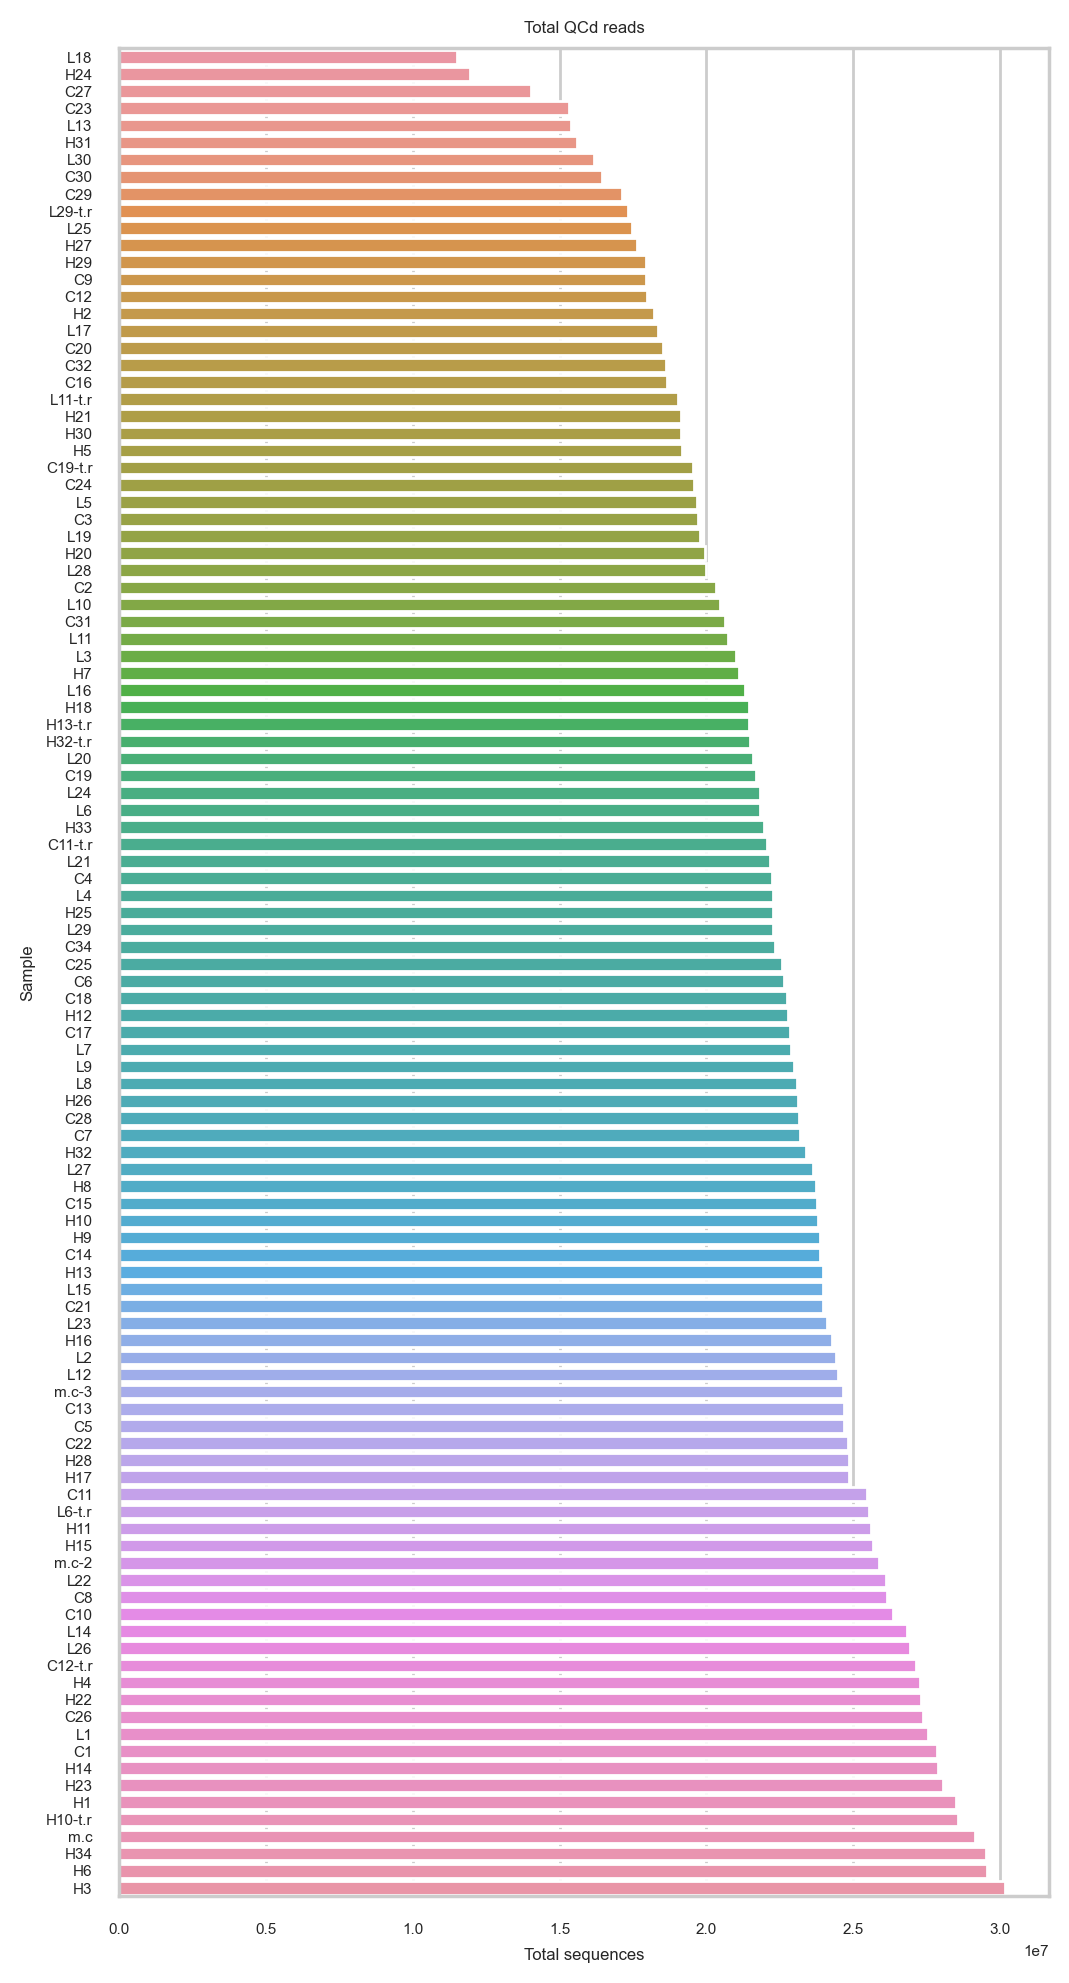

In [84]:
mqc_df = pd.read_csv("../atlas/multiqc/multiqc_data/multiqc_general_stats.txt", header=0, sep="\t", index_col=0)
mqc_df.rename(columns = lambda x: x.replace("FastQC_mqc-generalstats-fastqc-", ""), inplace=True)
mqc_df.rename(columns = lambda x: x.replace("BBDuk_mqc-generalstats-bbduk-", ""), inplace=True)
mqc_df_bbduk = mqc_df.loc[mqc_df.index.str.contains("deduplicated")]
mqc_df_fastqc = mqc_df.loc[~mqc_df.index.str.contains("deduplicated")]
mqc_df_fastqc = mqc_df_fastqc.assign(sample_id=pd.Series([re.sub("_QC_R[12]", "", x) for x in mqc_df_fastqc.index], index=mqc_df_fastqc.index))
fig = plt.figure(figsize=(6,12))
x = mqc_df_fastqc.sort_values("total_sequences").loc[mqc_df_fastqc.index.str.endswith("R1"), "total_sequences"].values
y = mqc_df_fastqc.sort_values("total_sequences").loc[mqc_df_fastqc.index.str.endswith("R1"), "sample_id"].values
sample_groups = [x[0] for x in y]
lut = dict(zip(set(sample_groups), sns.color_palette("Set2", len(set(sample_groups)))))
plt_data = pd.DataFrame(data={"x": x, "Sample": y, "Group": sample_groups})
with sns.plotting_context("notebook", font_scale=0.5):
    ax = sns.barplot(data=plt_data, x="x", y="Sample", )
    ax.set_xlabel("Total sequences");
    ax.set_title("Total QCd reads");

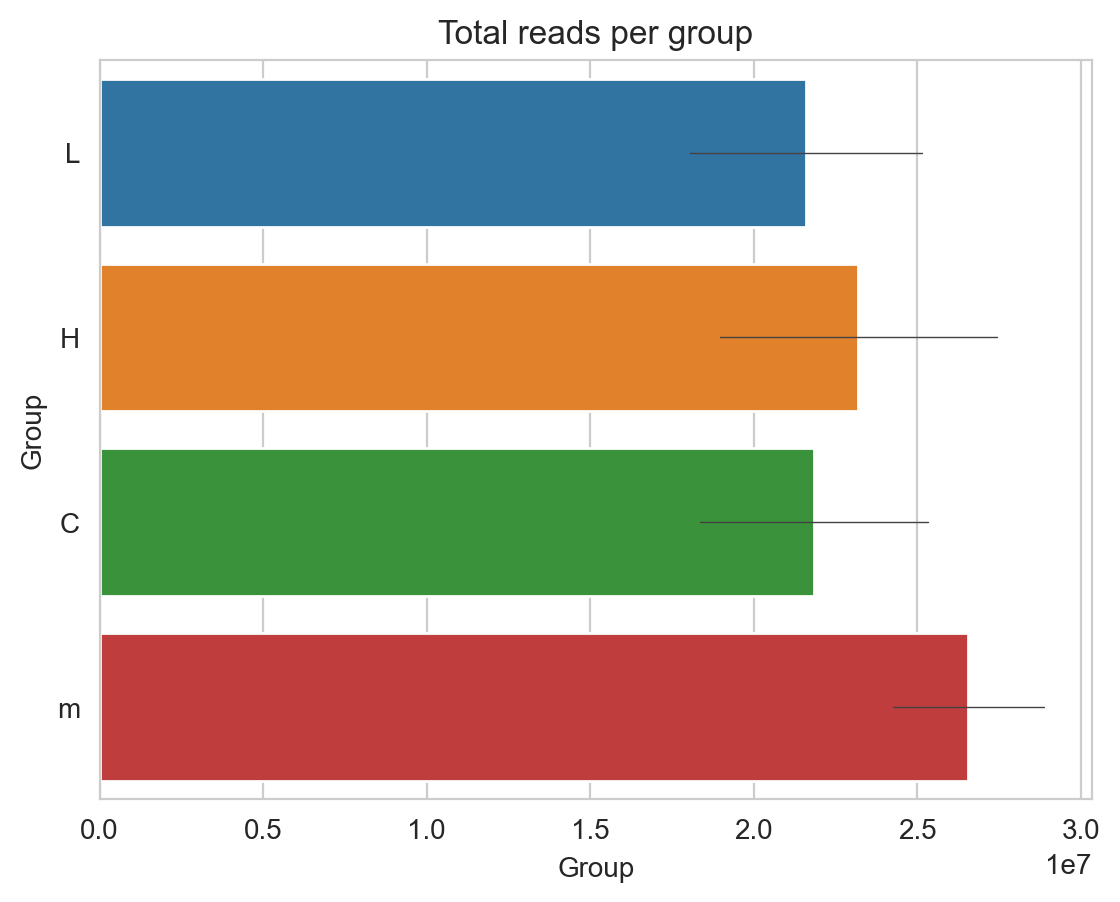

In [89]:
ax = sns.barplot(data=plt_data, x="x", y="Group", errorbar="sd", errwidth=.5)
ax.set_title("Total reads per group");
ax.set_xlabel("Group");

#### Atlas assemble

The `atlas run assembly` command produces a fasta file for each sample, maps the QCd reads against the contigs to produce a bam file and also generates some stats.

Here's how atlas was executed:

```bash
atlas run -w /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/atlas -c /proj/snic2020-5-486/nobackup/SMS-23-6668-micegut/conf/atlas-config.yml --profile cluster -n assembly
```

Updating `conf/atlas-config.yml` to give 20 threads and 128 GB memory to the megahit assembler.